# Projenin Amacı
Bu proje, trafik işaretlerinin görüntüler üzerinden Evrişimli Sinir Ağları (CNN) kullanılarak otomatik olarak sınıflandırılmasını hedeflemektedir. Trafik işaretlerinin doğru tanınması, otonom sürüş sistemleri ve sürücü destek teknolojileri için kritik bir adımdır.

Geliştirilen model, veri önişleme ve veri artırma (data augmentation) teknikleri ile eğitilerek 43 farklı trafik işareti sınıfını yüksek doğrulukla tanıyabilmektedir. Bu sayede, gerçek zamanlı uygulamalarda sürücülerin bilgilendirilmesi # ve güvenli sürüş senaryolarının desteklenmesi amaçlanmaktadır.

# Veri Seti Hakkında
* Görseller 32x32 piksel boyutunda, RGB formatındadır.

*Veri seti üç parçaya ayrılmıştır:

  * Eğitim (train)
  * Doğrulama (validation)
  * Test (test)

*Toplamda 43 farklı trafik işareti sınıfı bulunmaktadır.

*Görseller, çeşitli ışık koşulları, açılar ve çevresel faktörleri içerecek şekilde hazırlanmıştır.

# Kullanılan Yöntemler
**Veri Önişleme**

* Görsellerin normalize edilmesi (0–1 aralığına)
  
* Etiketlerin one-hot encoding ile dönüştürülmesi
  
* Train-validation-test ayrımı

**Data Augmentation**

* Rotation (döndürme)
  
* Width & Height Shift (kaydırma)
  
* Zoom
  
* Horizontal Flip

**Model Mimarisi = CNN**

* Üç adet evrişim (Convolutional) katmanı:
   * 32, 64 ve 64 filtre
   * ReLu aktivasyon fonksiyonu
     
* Her evrişim katmanından sonra MaxPooling katmanı

* Dropout katmanları: 0.5

* Tam bağlantılı (Dense) katman:
   * 64 nöron
   * Çıkış katmanı: 43 sınıf için Softmax aktivasyonu

**Model Değerlendirme**

* Accuracy & Loss grafikleri
  
* Confusion Matrix

* Classification Report

**Sonuç**

* Modelin eğitim doğruluğu %93+, doğrulama doğruluğu ise %90 civarında.

* Bu sonuçlar trafik işareti sınıflandırması için oldukça başarılı.

* Ufak overfitting olmasına rağmen, dropout ve learning rate azaltma stratejisi ile kontrol altına alındı.

In [1]:
# Dataset yüklendi
import os

data_path = "/kaggle/input/traffic-signs-preprocessed"

In [2]:
# Gerekli kütüphaneler yüklendi
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

2025-09-26 11:11:17.001064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758885077.240469      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758885077.306809      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ----------- Veri Önişleme -----------
# Dataset klasöründeki dosyalar listelendi
print("Files in dataset folder:")
print(os.listdir(data_path))

Files in dataset folder:
['mean_image_rgb.pickle', 'data5.pickle', 'data4.pickle', 'data7.pickle', 'data8.pickle', 'data1.pickle', 'data3.pickle', 'test.pickle', 'mean_image_gray.pickle', 'data6.pickle', 'data0.pickle', 'valid.pickle', 'data2.pickle', 'labels.pickle', 'datasets_preparing.py', 'std_gray.pickle', 'std_rgb.pickle', 'label_names.csv', 'train.pickle']


In [4]:
# Dataset içindeki pickle dosyalarının yolları tanımlandı
train_path = os.path.join(data_path, "train.pickle")
valid_path = os.path.join(data_path, "valid.pickle")
test_path  = os.path.join(data_path, "test.pickle")

In [5]:
# Veriler yüklendi
# train
with open(train_path, 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')
X_train, y_train = train_data['features'], train_data['labels']

# validation
with open(valid_path, 'rb') as f:
    valid_data = pickle.load(f, encoding='latin1')
X_valid, y_valid = valid_data['features'], valid_data['labels']

# test
with open(test_path, 'rb') as f:
    test_data = pickle.load(f, encoding='latin1')
X_test, y_test = test_data['features'], test_data['labels']

# Veri boyutları kontrol edildi
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (34799, 32, 32, 3) (34799,)
Valid: (4410, 32, 32, 3) (4410,)
Test: (12630, 32, 32, 3) (12630,)


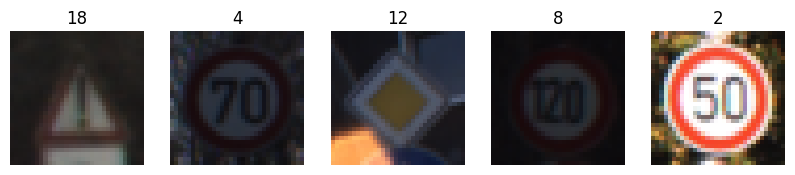

In [6]:
# Eğitim setinden rastgele 5 örnek görselleştirildi
indices = np.random.choice(len(X_train), size=5, replace=False)
plt.figure(figsize=(10,2))
for i, idx in enumerate(indices):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[idx])
    plt.title(y_train[idx])
    plt.axis('off')
plt.show()

In [7]:
# Normalization için veri tipi kontrolü
print(X_train.dtype)

uint8


In [8]:
# Etiket isimleri getirildi
labels = pd.read_csv(data_path + "/label_names.csv")

# İlk satır getirildi
print("label_names.csv içindeki ilk 5 satır:")
print(labels.head())

# Sınıf sayısı kontrolü
print("\nSınıf sayısı:", labels.shape[0])

# Tüm sınıf kimlikleri isimleriyle birlikte yazdırıldı
print("\nTüm trafik işaret sınıfları:")
for i, name in enumerate(labels['SignName']):
    print(f"{i}: {name}")

label_names.csv içindeki ilk 5 satır:
   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Sınıf sayısı: 43

Tüm trafik işaret sınıfları:
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ic

In [9]:
# Görseller normalize edildi (0 - 255 -> 0 - 1 aralığına)
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

In [10]:
# Label'lar One-Hot Encoding formatına çevrildi
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
# ---------- Data Augmentation ---------------
datagen = ImageDataGenerator(
    rotation_range=15,       # resmi 15 dereceye kadar döndürme
    width_shift_range=0.1,   # yatay kaydırma
    height_shift_range=0.1,  # dikey kaydırma
    zoom_range=0.1,          # yakınlaştırma/uzaklaştırma
    horizontal_flip=True,     # yatay ayna simetrisi
)

# Veri artırma işlemi eğitim verisine uygulandı
datagen.fit(X_train)

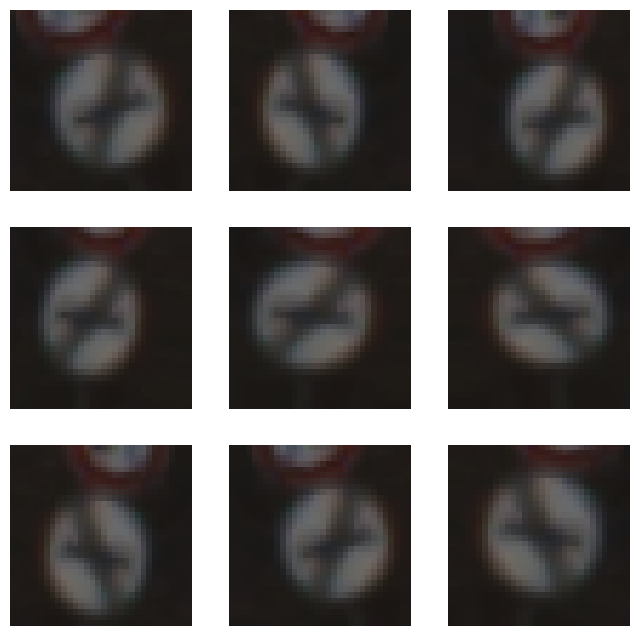

In [12]:
# Örnek olarak ilk görüntü getirildi
x = X_train[0].reshape((1,) + X_train[0].shape)  # (1, 32, 32, 3)

plt.figure(figsize=(8,8))
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0])
    plt.axis('off')
    i += 1
    if i == 9:  # 9 farklı augment edilmiş örnek göster
        break
plt.show()

In [13]:
# --------- Modelin Eğitilmesi -----------
# CNN Modeli
# Model oluşturuldu
model = tf.keras.Sequential()

In [14]:
# Katmanlar oluşturuldu 
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

2025-09-26 11:11:35.471630: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
# Model özeti 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,715 (487.17 KB)

 Trainable params: 124,715 (487.17 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Model derlendi
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Overfitting durumunu engellemek/dengelemek için
# Erken durdurma ile doğrulama kaybı uzun süre iyileşmezse eğitim durur
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Öğrenme oranını azaltma ile val_loss iyileşmezse öğrenme oranı küçültülür
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Model eğitildi
results = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.1199 - loss: 3.2716 - val_accuracy: 0.3279 - val_loss: 2.0800 - learning_rate: 0.0010
Epoch 2/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.3164 - loss: 2.1710 - val_accuracy: 0.4293 - val_loss: 1.7038 - learning_rate: 0.0010
Epoch 3/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.3868 - loss: 1.8436 - val_accuracy: 0.4626 - val_loss: 1.5592 - learning_rate: 0.0010
Epoch 4/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.4299 - loss: 1.6899 - val_accuracy: 0.5057 - val_loss: 1.3448 - learning_rate: 0.0010
Epoch 5/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.4736 - loss: 1.5373 - val_accuracy: 0.5664 - val_loss: 1.2324 - learning_rate: 0.0010
Epoch 6/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.5114 - loss: 1.4122 - val_accuracy: 0.6730 - val_loss: 1.0602 - learning_rate: 0.0010
Epoch 7/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.5621 - l

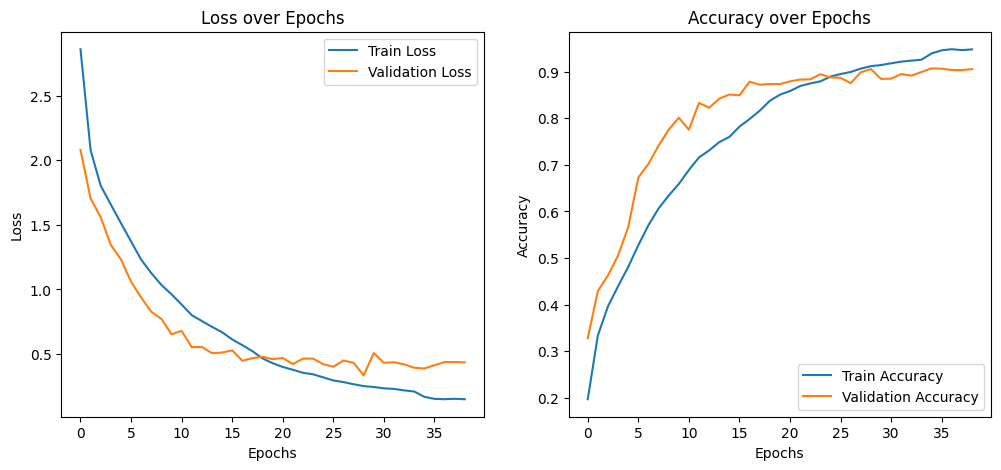

In [18]:
# --------- Modelin Değerlendirilmesi ----------
plt.figure(figsize=(12,5))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Modelin eğitim ve doğrulama başarımları birlikte artmış, aralarında belirgin bir fark oluşmamıştır. Validation loss uzun süre sabit kalarak aşırı öğrenmenin (overfitting) engellendiğini göstermektedir. EarlyStopping ve ReduceLROnPlateau callback’leri sayesinde eğitim süreci optimize edilmiştir. Sonuç olarak model yaklaşık %90 üzeri doğruluk ile genelleme yapabilmektedir.**

Test Kaybı: 0.3249
Test Doğruluğu: 0.9218
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85        60
           1       0.92      0.97      0.95       720
           2       0.90      0.95      0.92       750
           3       0.96      0.87      0.91       450
           4       0.98      0.95      0.97       660
           5       0.87      0.85      0.86       630
           6       0.97      0.97      0.97       150
           7       0.96      0.96      0.96       450
           8       0.93      0.95      0.94       450
           9       0.99      1.00      1.00       480
          10       0.99      1.00      0.99       660
          11       0.96      0.96      0.96       420
          12       1.00      0.94      0.97       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      

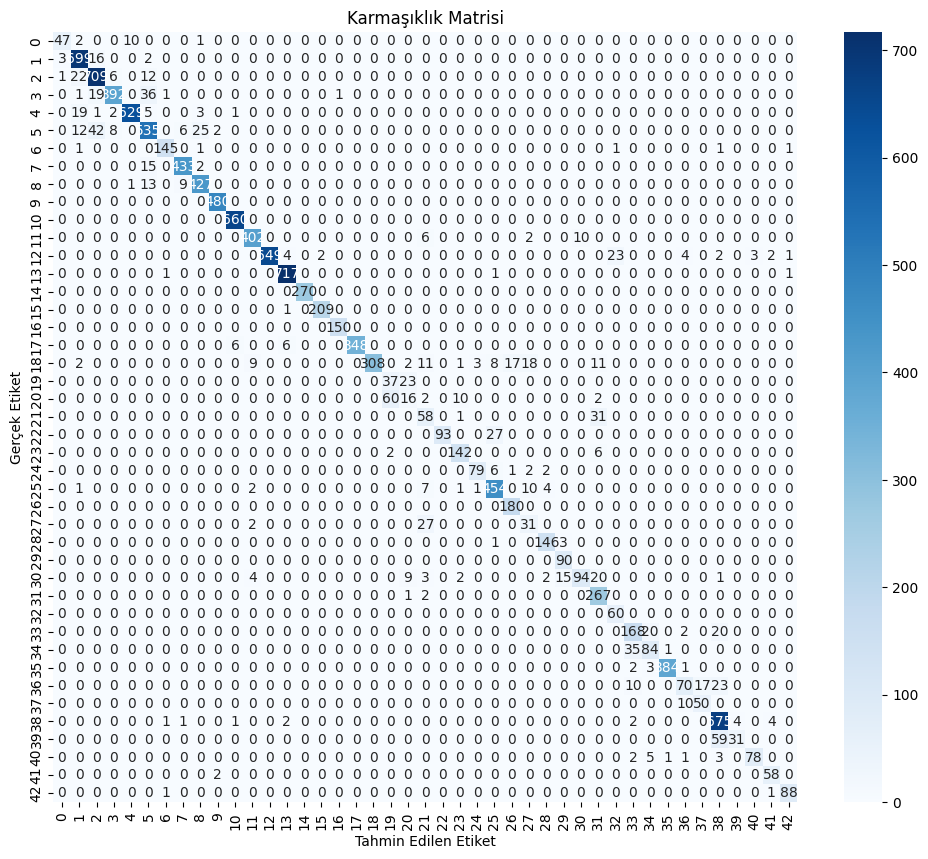

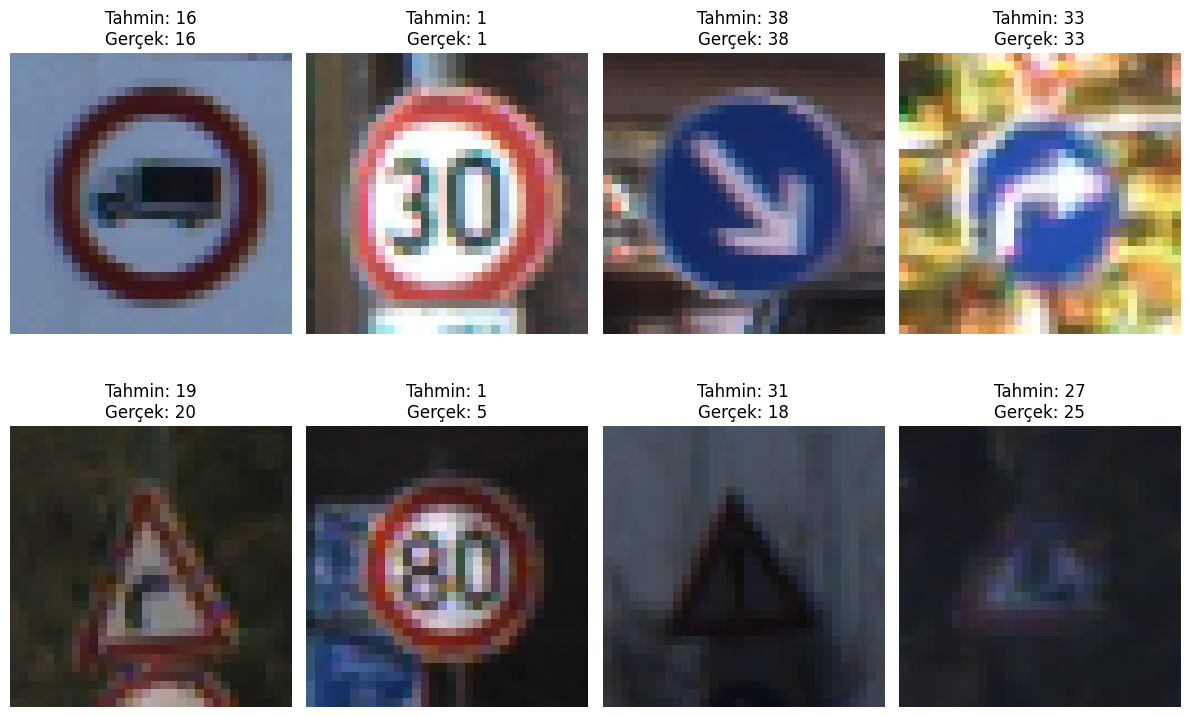

In [19]:
# Test seti üzerinde değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

# Tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Doğru ve Yanlış tahmin örnekleri
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# İlk 4 doğru tahmin gösterimi
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct])
    plt.title(f"Tahmin: {y_pred_classes[correct]}\nGerçek: {y_true[correct]}")
    plt.axis('off')

# İlk 4 yanlış tahmin gösterimi
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {y_pred_classes[incorrect]}\nGerçek: {y_true[incorrect]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Sınıflandırma modeline göre model genel olarak %91 doğrulukla iyi performans gösteriyor ve çoğu sınıfı doğru sınıflandırıyor. Ancak bazı az örnekli sınıflarda (ör. 19, 20, 27, 37) ciddi yanlış sınıflandırmalar var, bu da veri dengesizliği ve sınıf sayısının az olmasından kaynaklanıyor.**

**Karmaşıklık Matrisi (Confusion Matrix) incelendiğinde, modelin performansının mükemmele yakın olduğu görülmüştür. Tahminlerin büyük çoğunluğu ana köşegen üzerinde yoğunlaşmaktadır ve bu, modelin genelleme yeteneğinin yüksek olduğunu ve trafik işaretlerini ayırt etme görevinde güvenilir ve tutarlı çalıştığını göstermektedir. Bu model yapısı, overfitting sorunu olmayan başarılı bir temel oluşturmaktadır.**

In [20]:
# Heatmap Görselleştirme 
# Model Sequential'dı, Grad-CAM'de kullanılabilmesi için Functional API ile yeniden oluşturuldu
inputs = tf.keras.Input(shape=(32,32,3))
x = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu", name="last_conv")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Grad-CAM için Functional model oluşturuldu
last_conv_layer = model.get_layer("last_conv")
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[last_conv_layer.output, model.output]
)

In [22]:
# Grad-CAM fonksiyonu
def get_gradcam(grad_model, image):
    img_array = np.expand_dims(image, axis=0)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    
    return heatmap 

In [23]:
def overlay_gradcam(image, heatmap, alpha=0.4):
    # cv2 kullanımı için "import cv2" en üstte olmalı
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlayed_image

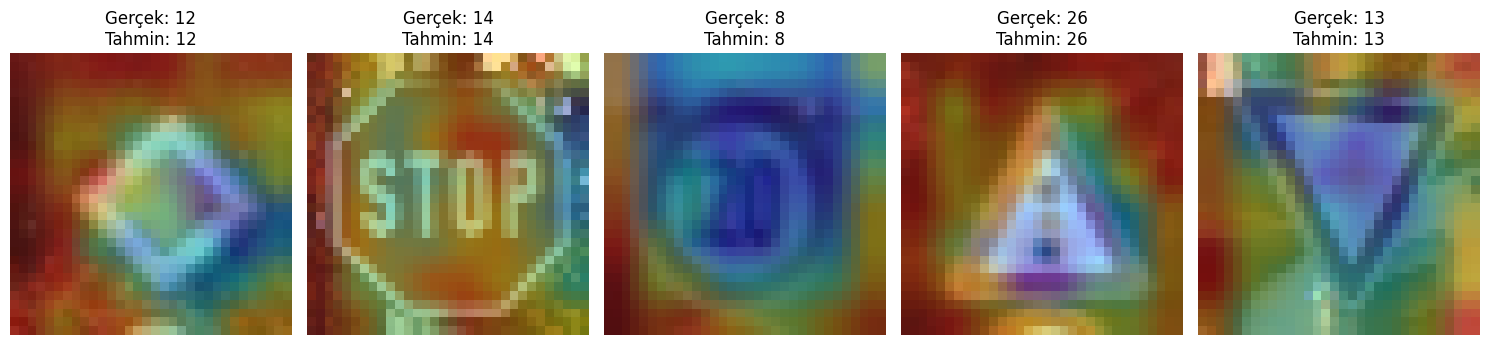

In [24]:
#Görselleştirme yapıldı

indices = np.random.choice(len(X_test), size=5, replace=False)
plt.figure(figsize=(15,5))

for i, idx in enumerate(indices):
    image = X_test[idx]
    heatmap = get_gradcam(grad_model, image)
    
    # overlay_gradcam fonksiyonu artık tanımlı olduğu için hata vermeyecektir
    overlay = overlay_gradcam((image * 255).astype('uint8'), heatmap) 
    
    plt.subplot(1,5,i+1)
    plt.imshow(overlay)
    plt.title(f"Gerçek: {y_true[idx]}\nTahmin: {y_pred_classes[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
# ----- Hiperparametre Optimizasyonu ------
from tensorflow.keras import regularizers

model = tf.keras.Sequential()
# Conv1
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', 
                                 input_shape=(32,32,3),
                                 kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.4))

# Conv2
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu',
                                 kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.4))

# Conv3
model.add(tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu',
                                 kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.4))

# Dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(96, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │       147,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         4,171 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,507 (884.79 KB)

 Trainable params: 226,507 (884.79 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

results = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - accuracy: 0.1054 - loss: 3.5449 - val_accuracy: 0.3320 - val_loss: 2.4611 - learning_rate: 0.0010
Epoch 2/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.3131 - loss: 2.3913 - val_accuracy: 0.4163 - val_loss: 2.0320 - learning_rate: 0.0010
Epoch 3/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.4102 - loss: 2.0405 - val_accuracy: 0.4567 - val_loss: 1.8340 - learning_rate: 0.0010
Epoch 4/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.4626 - loss: 1.8562 - val_accuracy: 0.5048 - val_loss: 1.6701 - learning_rate: 0.0010
Epoch 5/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.5162 - loss: 1.7073 - val_accuracy: 0.5971 - val_loss: 1.5080 - learning_rate: 0.0010
Epoch 6/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - accuracy: 0.5501 - loss: 1.6210 - val_accuracy: 0.6084 - val_loss: 1.4389 - learning_rate: 0.0010
Epoch 7/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.5883 - l

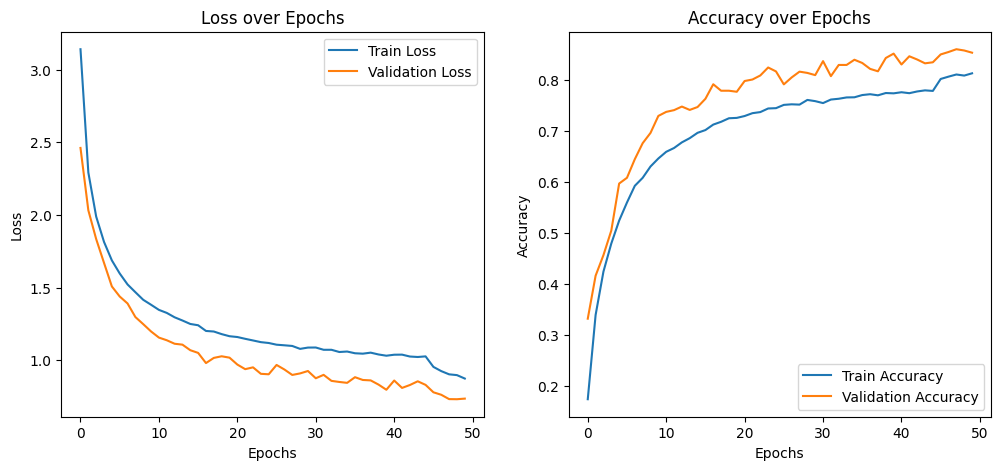

Test Kaybı: 0.7444
Test Doğruluğu: 0.8617
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.13      0.24        60
           1       0.88      0.85      0.86       720
           2       0.59      0.97      0.74       750
           3       0.99      0.69      0.81       450
           4       0.99      0.93      0.96       660
           5       0.66      0.47      0.55       630
           6       0.99      0.95      0.97       150
           7       0.98      0.71      0.83       450
           8       0.80      0.95      0.87       450
           9       0.99      1.00      1.00       480
          10       0.99      0.98      0.99       660
          11       0.98      0.87      0.92       420
          12       0.96      0.91      0.93       690
          13       0.97      1.00      0.98       720
          14       0.99      1.00      0.99       270
          15       0.96     

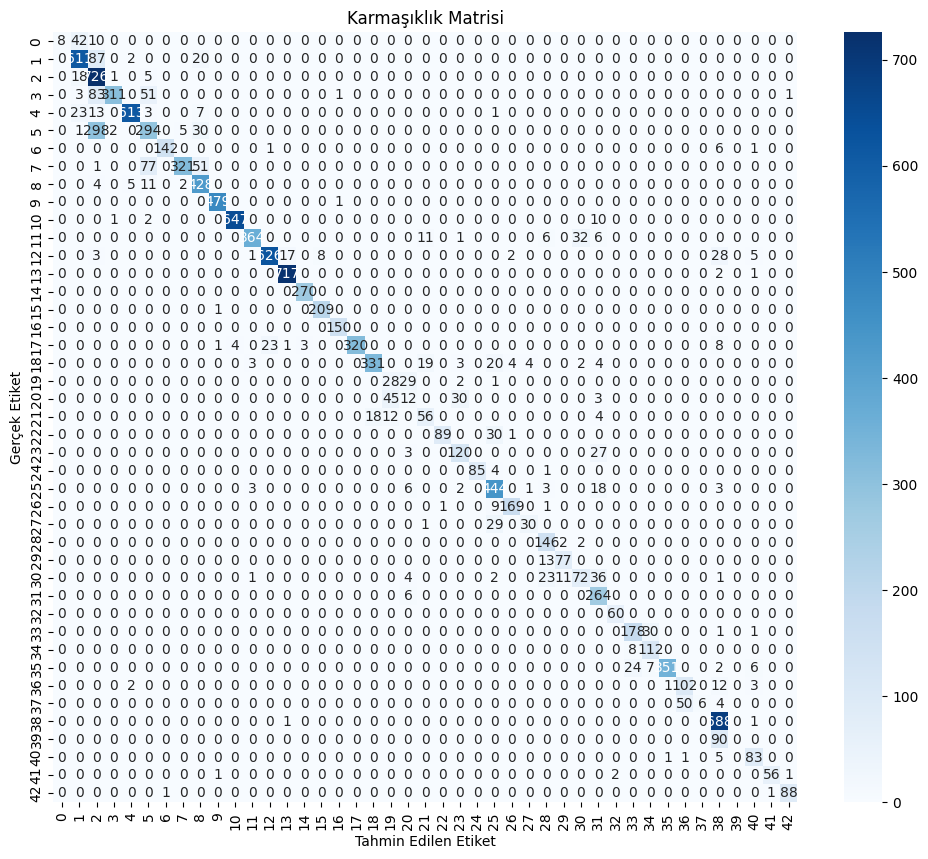

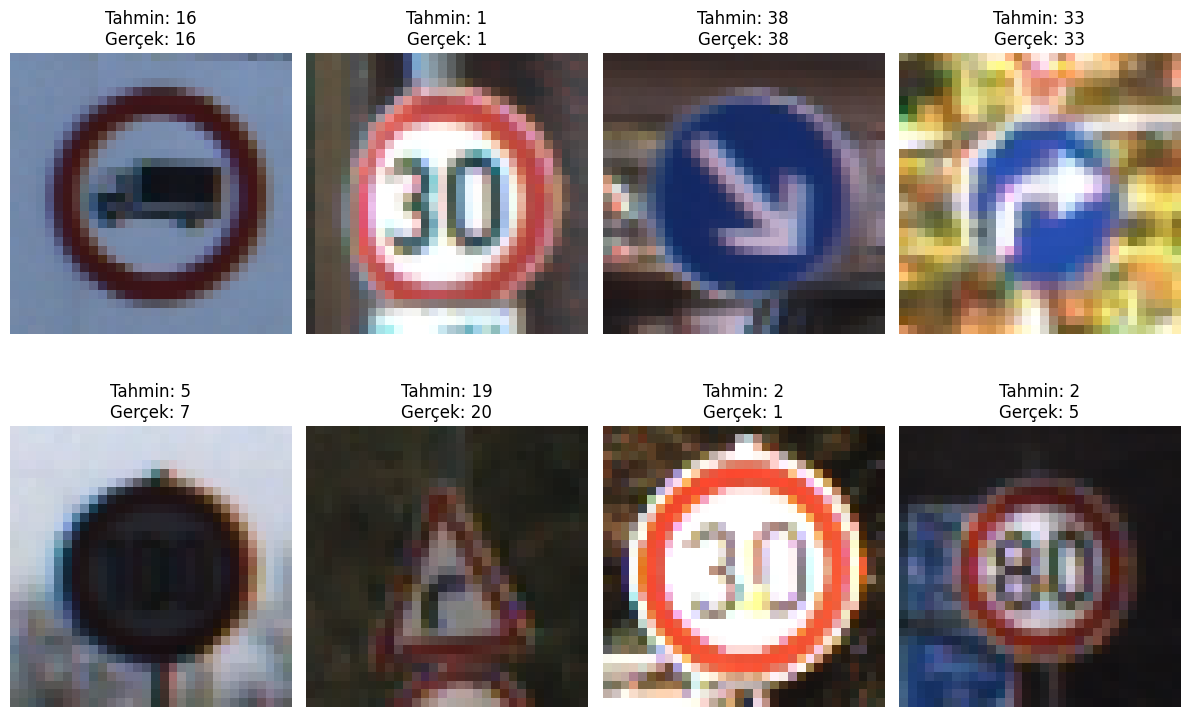

In [28]:
plt.figure(figsize=(12,5))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test seti üzerinde değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

# Tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Doğru ve Yanlış tahmin örnekleri
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# İlk 4 doğru tahmin gösterimi
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct])
    plt.title(f"Tahmin: {y_pred_classes[correct]}\nGerçek: {y_true[correct]}")
    plt.axis('off')

# İlk 4 yanlış tahmin gösterimi
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {y_pred_classes[incorrect]}\nGerçek: {y_true[incorrect]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Hiperparametre optimizasyonu kapsamında daha derin ve karmaşık bir CNN modeli denendi. Eğitim başarımı yüksek olmasına rağmen, doğrulama başarımı aynı seviyeye ulaşamadı. Train/validation kayıpları ve doğruluk grafikleri incelendiğinde overfitting gözlenmiştir. Bu deneme, modelin kapasitesinin veri seti için fazla olduğunu göstermektedir. Bu nedenle final model olarak daha dengeli sonuçlar veren ilk CNN modeli seçildi.**

**Sınıflandırma raporuna göre model genel olarak büyük sınıflarda iyi performans gösterse de, küçük sınıflarda ciddi hatalar yapıyor ve overfitting gösteriyor.**

**Karmaşıklık Matrisi, modelin hala yüksek bir genel doğruluğa sahip olduğunu gösterse de, overfitting'in somut etkilerini barındırmaktadır. Matristeki ana köşegenin dışında, özellikle görsel olarak benzer işaretlerin (örneğin hız limitleri) kesişim noktalarında belirgin hata kümeleri oluşmuştur. Bu, modelin eğitim verisini ezberlediği ve doğrulama/test verilerindeki ince farkları doğru şekilde genelleştiremediği anlamına gelir. Model, görevini çözmüş olsa da, tutarlılık ve güvenilirlik açısından ilk modelin gerisinde kalmaktadır.**